# Developing an Autoencoder (AE) for Behavorial Representation Learning:

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras import layers, models
from typing import Tuple
from sklearn.preprocessing import StandardScaler

### Defining Autoencoder Class:

In [2]:
class Autoencoder:
    """
    Autoencoder for learning latent representation of UEBA behavioral features.
    """
    
    def __init__(self, input_dim: int, latent_dim: int=16, hidden_dim: int=32, learning_rate: float=1e-3) -> None:
        """
        Initializes the autoencoder architecture.
        
        Args:
            input_dim: The number of input features
            latent_dim: The size of latent embeddings
            hidden_dim: The size of hidden layers
            learning_rate: Optimizer learning rate
            
        Returns:
            None:
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        
        self.autoencoder, self.encoder = self._build_model()
        
    
    def _build_model(self) -> tuple:
        """
        Builds the autoencoder and encoder models. The autoencoder serves as the model to train, whereas the encoder
        will be utilized for extracting behavioral embeddings.
        
        Args:
            None:
        
        Returns:
            tuple: A two-element tuple containing the autoencoder and encoder models
        """
        # Encoder construction
        inputs = layers.Input(shape=(self.input_dim,), name="ueba_input")
        x = layers.Dense(self.hidden_dim, activation="relu")(inputs)
        latent = layers.Dense(self.latent_dim, activation="relu", name="latent_space")(x)
        
        # Decoder construction
        x = layers.Dense(self.hidden_dim, activation="relu")(latent)
        outputs = layers.Dense(self.input_dim, activation="linear")(x)
        
        # Defining the autoencoder and encoder
        autoencoder = models.Model(inputs, outputs, name="ueba_autoencoder")
        encoder = models.Model(inputs, latent, name="ueba_encoder")
        
        # Compiling the autoencoder
        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(self.learning_rate),
            loss="mse"
        )
        
        return (autoencoder, encoder)
    
    
    def train(self, x_train: np.ndarray, save_path: str, epochs: int=50, batch_size: int=128, validation_split: float=0.1):
        """
        Trains the autoencoder using the specified hyperparameters.
        
        Args:
            x_train: The scaled UEBA-enhanced feature matrix
            save_path: The path to store the training log
            epochs: The number of epochs to train the autoencoder for
            batch_size: Batch size
            validation_split: The validation data ratio
        """
        # Defining logger to save training history
        log_save_path = os.path.join(save_path, "training_log.csv")
        csv_logger = tf.keras.callbacks.CSVLogger(log_save_path, append=True)
        
        # Training the full autoencoder
        history = self.autoencoder.fit(
            x_train,
            x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            shuffle=True,
            verbose=1,
            callbacks=[csv_logger]
        )
        
        return history
        
    
    def encode(self, feature_matrix: np.ndarray) -> np.ndarray:
        """
        Generates latent embeddings for UEBA data.
        
        Args:
            feature_matrix: The scaled UEBA feature matrix
            
        Returns:
            np.ndarray: The generate latent embeddings
        """
        return self.encoder.predict(feature_matrix)
    
    
    def reconstruction_error(self, feature_matrix: np.ndarray) -> np.ndarray:
        """
        Computes the reconstruction error per sample.
        
        Args:
            feature_matrix: The scaled UEBA feature matrix
            
        Returns:
            np.ndarray: Reconstruction MSE per sample
        """
        # Reconstructing original feature matrix
        reconstruction = self.autoencoder.predict(feature_matrix)
        
        # Computing the mean sqaured error
        error = np.mean(np.square(feature_matrix - reconstruction), axis=1)
        
        return error

### Loading UEBA-Enhanced Feature Matrix:

In [3]:
ueba_matrix = pd.read_csv(r"processed_datasets\ueba_dataset.csv", index_col=0)

In [4]:
ueba_matrix.head()

,user,pc,day,logon_count,logoff_count,off_hours_logon,file_open_count,file_write_count,file_copy_count,file_delete_count,...,usb_remove_count_rolling_delta,off_hours_usb_usage_rolling_delta,emails_sent_rolling_delta,unique_recipients_rolling_delta,external_emails_rolling_delta,attachements_sent_rolling_delta,off_hours_emails_rolling_delta,usb_file_activity_flag,off_hours_activity_flag,external_comm_activity_flag
0,aab0162,pc-6599,2010-01-04,1,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
1,aab0162,pc-6599,2010-01-05,1,1,2,0,0,0,0,...,0.0,0.0,0.0,1.5,0.000000,0.500000,-2.500000,0,0,1
2,aab0162,pc-6599,2010-01-06,1,1,2,0,0,0,0,...,0.0,0.0,0.0,1.0,-0.666667,-0.333333,3.666667,0,1,0
3,aab0162,pc-6599,2010-01-07,1,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.000000,-0.250000,0.500000,0,1,1
4,aab0162,pc-6599,2010-01-08,1,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.800000,-1.000000,-3.600000,0,0,1


In [5]:
# Extracting numeric features only
x = ueba_matrix.drop(columns=["user", "pc", "day"]).values

In [6]:
# Standardizing feature matrix
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

### Initializing and Training Autoencoder:

In [ ]:
# Defining save path for current training iteration
save_path = r"encoders\encoder_model_1"
os.makedirs(save_path, exist_ok=True)

In [ ]:
ae = Autoencoder(
    input_dim=x_scaled.shape[1],
    latent_dim=16,
    hidden_dim=32
)

In [9]:
history = ae.train(x_train=x_scaled, save_path=save_path, epochs=40, batch_size=128)

Epoch 1/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.1444 - val_loss: 0.1187
Epoch 2/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0992 - val_loss: 0.1050
Epoch 3/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0917 - val_loss: 0.0967
Epoch 4/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 11s 983us/step - loss: 0.0849 - val_loss: 0.0924
Epoch 5/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 10s 902us/step - loss: 0.0825 - val_loss: 0.0896
Epoch 6/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 10s 862us/step - loss: 0.0785 - val_loss: 0.0819
Epoch 7/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 9s 844us/step - loss: 0.0729 - val_loss: 0.0776
Epoch 8/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 10s 927us/step - loss: 0.0706 - val_loss: 0.0766
Epoch 9/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 9s 858us/step - loss: 0.0693 - val_loss: 0.0748
Epoch 10/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 10s 868us/step - loss: 0.0682 - val_loss: 0.0744
Epoch 11/40
11003/11003 ━━━━━━━━━━━━━━━━━━━━ 10s 862us/step - loss: 0.0672 - 

### Plotting Autoencoder Training History:

In [10]:
def plot_loss(history, save_path) -> None:
    """
    Plots the training loss against the validation loss for the autoencoder.
    
    Args:
        history: The history object (i.e., a record of training and validation metrics)
        save_path: The path where the plotted loss will be saved
        
    Returns:
        None:
    """
    plt.figure(figsize=(8, 4))
    plt.plot(history.epoch, history.history["loss"], "b", marker=".", label="Training Loss")
    plt.plot(history.epoch, history.history["val_loss"], "g", marker=".", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xlim(left=0.0)
    plt.ylim(bottom=0.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title("Loss History")
    plt.savefig(os.path.join(save_path, "Loss.png"))
    plt.show()

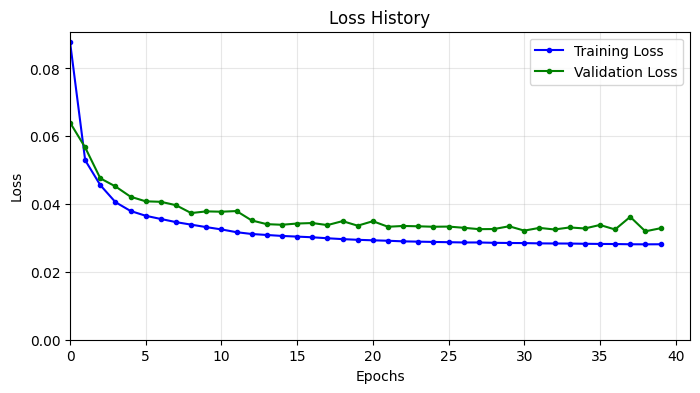

In [11]:
plot_loss(history, save_path)

### Generating Latent Embeddings:

In [12]:
# Generating embeddings
latent_embeddings = ae.encode(x_scaled)

48900/48900 ━━━━━━━━━━━━━━━━━━━━ 22s 442us/step


### Saving Encoder, Scaler, and Embeddings:

In [13]:
# Saving the full autencoder and encoder model
ae.autoencoder.save(os.path.join(save_path, "autoencoder_model.keras"))
ae.encoder.save(os.path.join(save_path, "encoder_model.keras"))

In [14]:
# Saving the trained scaler to prevent future behavorial drift
joblib.dump(scaler, os.path.join(save_path, r"feature_scaler.pkl"))

['encoders\\encoder_model_1\\feature_scaler.pkl']

In [15]:
# Saving the embeddings generated by the encoder
np.save(os.path.join(save_path, "latent_embeddings.npy"), latent_embeddings)